### Выводы по работе

1. Создание новых признаков почти невозможно из-за кодирования информации (высокий шанс испортить данные из-за их не понимания)
2. Дефолтных должников по отношению к нормальным должникам примерно 1:29 (сильный дисбаланс)
3. a) При построении работы использовались три модели (MLPClassifier, LogisticRegression, GradientBoosingClassifier
3. b) Выбор лучшей модели производился только на одном паркете из-за ограниченности ресурсов
3. с) Методы правки количества данных не производились (downsampling - можно потерять часть важный данных,
                                                        upsampling - можно увеличить шум (т.к. данных вообще не знаем),
                                                        SMOTE аналаогично может навредить модели, генерируя шум)
4. Подбор гиперпараметров производился также только 30% данных из-за ограниченности мощности
5. Переобученность модели проверялась на всех данных с помощью cross_val_score

Более подробные комментарии есть по работе ниже

### Импорт библиотек

In [1]:
import os
import gc
import pandas as pd
import tqdm
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, auc

import dill as dill

import warnings
warnings.filterwarnings("ignore")

In [2]:
def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразовывает их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой нужно начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('train')])
    print(dataset_paths)

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        chunk = pd.read_parquet(chunk_path,columns=columns)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)

In [3]:
def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int=50,
                                 save_to_path=None, verbose: bool=False):
    """
    возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи
    path_to_dataset: str
        путь до датасета с партициями
    num_parts_to_preprocess_at_once: int
        количество партиций, которые будут одновременно держаться и обрабатываться в памяти
    num_parts_total: int
        общее количество партиций, которые нужно обработать
    save_to_path: str
        путь до папки, в которой будет сохранён каждый обработанный блок в .parquet-формате; если None, то не будет сохранён
    verbose: bool
        логирует каждую обрабатываемую часть данных
    """
    preprocessed_frames = []
    npl_frames = []
    
    counts_npl = ['pre_loans5', 'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90']
    mark_npl = ['is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90']
    incl_npl = counts_npl + mark_npl + ['id']
    
    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once,
                                                             verbose=verbose)
   
   #здесь должен быть препроцессинг данных
        for col in transactions_frame.drop('id', axis=1).columns:
            transactions_frame[col] = transactions_frame[col].astype('int8')
        transactions_frame['id'] = transactions_frame['id'].astype('int32')
        
        transactions_NPL = npl_all_buckets(transactions_frame[incl_npl], counts_npl, mark_npl)
        transactions_frame = ohe_transformation(transactions_frame.drop(mark_npl, axis=1))
        
   #записываем подготовленные данные в файл
        if save_to_path:
            block_as_str = str(step)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))
        
        preprocessed_frames.append(transactions_frame)      
        npl_frames.append(transactions_NPL)

    preprocessed_frames = pd.concat(preprocessed_frames)
    npl_frames = pd.concat(npl_frames)
    preprocessed_frames = preprocessed_frames.merge(npl_frames, on="id")
    preprocessed_frames.fillna(np.uint8(0), inplace=True)
    
    return preprocessed_frames

In [4]:
# Функция для OHE-кодирования с суммированием после категориальных признаков по коду клиенту (id)
def ohe_transformation(datafr):
    ohe = OneHotEncoder(sparse=False, dtype='int8')
    col_for_ohe = datafr.drop(['id', 'rn', 'pre_loans_total_overdue'],axis=1).columns
    
    ohe_dats = ohe.fit_transform(datafr[col_for_ohe])
    datafr[ohe.get_feature_names_out()] = ohe_dats
    datafr.drop(col_for_ohe, axis=1, inplace=True)
    
    datafr.groupby("id")
    rez_fr = datafr.groupby("id")[ohe.get_feature_names_out()].sum().reset_index(drop=False)
    return rez_fr

In [5]:
# Функция для получения процента просрочки по клиенту в каждой корзине (подробнее описано ниже в работе)
def npl_all_buckets(datafr, c_npl, m_npl)-> pd.DataFrame:
    buckets = {'pre_loans5': 6,
               'pre_loans530': 16,
               'pre_loans3060': 5,
               'pre_loans6090': 4,
               'pre_loans90': 8}
    
    all_id = datafr.groupby('id')['id'].count().reset_index(name='all_count')
    
    for i in range(len(c_npl)):
        zero = datafr[(datafr[c_npl[i]] == buckets[c_npl[i]]) & (datafr[m_npl[i]] == 1)].groupby('id')[c_npl[i]].count().reset_index(name='count_0')
        all_id = all_id.merge(zero[['id', 'count_0']], on='id', how="outer")
        
        name_out = 'perc_' + c_npl[i]
        all_id[name_out] = round(1 - all_id['count_0'] / all_id['all_count'], 2).astype('float32')
        all_id.drop('count_0', axis=1, inplace=True)
        
    all_id.fillna(np.uint8(1), inplace=True)    
    end_frame = all_id.drop(['all_count'], axis=1)
    return end_frame

In [6]:
path = 'train_data/'

In [7]:
data = prepare_transactions_dataset(path, num_parts_to_preprocess_at_once=6, num_parts_total=12,
                                    save_to_path='train_data/')

Transforming transactions data:   0%|          | 0/2 [00:00<?, ?it/s]

['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/6 [00:00<?, ?it/s]

chunk_path train_data/train_data_0.pq
chunk_path train_data/train_data_1.pq
chunk_path train_data/train_data_10.pq
chunk_path train_data/train_data_11.pq
chunk_path train_data/train_data_2.pq
chunk_path train_data/train_data_3.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/6 [00:00<?, ?it/s]

chunk_path train_data/train_data_4.pq
chunk_path train_data/train_data_5.pq
chunk_path train_data/train_data_6.pq
chunk_path train_data/train_data_7.pq
chunk_path train_data/train_data_8.pq
chunk_path train_data/train_data_9.pq


### Вес одного паркета данных

In [8]:
memory_usage_of_frame = data.memory_usage(index=True).sum() / 10**9

In [9]:
memory_usage_of_frame

1.683000132

### Количество строк и столбцов после всех обработок по всему массиву данных

In [8]:
data.shape

(3000000, 413)

### Информация по значениям по столбцам по всему датафрейму

In [17]:
for col in data.columns:
    print(data[col].value_counts(dropna=False))
    print(10 * '*')

id
2891734    58
1782755    55
1658519    54
62963      51
508303     51
           ..
2349517     1
1108612     1
883552      1
1903673     1
2531540     1
Name: count, Length: 3000000, dtype: int64
**********
rn
1     3000000
2     2779455
3     2550810
4     2320731
5     2094188
6     1876509
7     1668536
8     1473997
9     1294408
10    1130303
11     982254
12     850192
13     733250
14     630295
15     540573
16     457926
17     383308
18     315058
19     254553
20     201566
21     156755
22     120002
23      90835
24      67755
25      50452
26      37382
27      27698
28      20450
29      15053
30      11050
31       8006
32       5815
33       4185
34       2964
35       2063
36       1447
37        987
38        662
39        441
40        280
41        178
42        123
43         75
44         41
45         32
46         17
47         12
48         10
49          9
50          7
51          5
52          3
53          3
54          3
55          2
56          1
57

enc_paym_22
3    20332673
0     5435204
1      365132
2       29708
Name: count, dtype: int64
**********
enc_paym_23
3    20634992
0     5157075
1      342900
2       27750
Name: count, dtype: int64
**********
enc_paym_24
4    21966247
1     3919903
2      251452
3       25115
Name: count, dtype: int64
**********
enc_loans_account_holder_type
1    25807322
3      213021
4      117422
6       20625
5        2232
2        2031
0          64
Name: count, dtype: int64
**********
enc_loans_credit_status
3    17561773
2     8276203
4      201958
5       68431
1       48568
6        3803
0        1981
Name: count, dtype: int64
**********
enc_loans_credit_type
4    14774986
3     7736233
5     1050346
1      880196
0      756480
2      617386
7      310217
6       36873
Name: count, dtype: int64
**********
enc_loans_account_cur
1    26100882
2       53102
0        8550
3         183
Name: count, dtype: int64
**********
pclose_flag
0    22259294
1     3903423
Name: count, dtype: int64
*********

Из этого можем увидеть, что данные довольно сложно обработать (создать новые признаки) из-за отсутствия понимания, что скрывается за кодировкой. Пустых значений нет. Можно удалить признак "pre_loans_total_overdue", т.к. он имеет всего 1 отличное значение.
При моделировании можно понизить размерность всех столбцов (кроме id) до int8, т.к. нет значений выходящих за этот диапазон.
Ниже подробно разобрана возможность создания признаков по флагам и кол-ву просрочки 

In [8]:
counts_npl = ['pre_loans5', 'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90']
mark_npl = ['is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90']

for i in range(len(counts_npl)):
    print(data.groupby([counts_npl[i],mark_npl[i]], as_index=True)[counts_npl[i]].count())
    print(100 * "-")

pre_loans5  is_zero_loans5
0           0                    95329
1           0                       91
2           0                     4386
3           0                    28998
5           0                    11810
6           0                  1983537
            1                 24035861
7           0                      250
8           0                       32
9           0                       13
10          0                        1
11          0                        3
13          0                      640
16          0                     1766
Name: pre_loans5, dtype: int64
----------------------------------------------------------------------------------------------------
pre_loans530  is_zero_loans530
0             0                     110507
1             0                        138
2             0                       4433
3             0                       9117
4             0                        575
5             0                          5
6     

Из флагов нет просрочек до N дней и кол-во просрочек до N дней, можно выделить по каждому клиенту долю договоров, которые не выходили на просроченную задолженность до N дней, т.е получить условный коэффициент вероятности возникновения просроченной задолженности по клиенту в каждой группе N дней:

1 - (кол-во договоров с отсутствием просрочки по клиенту в N группе/ общее количество договоров клиента)

чем выше коэффициент, тем выше вероятность перехода в N корзину просрочки клиента

### Информация по целевой переменной

In [12]:
targets = pd.read_csv('train_target.csv')
targets.flag.value_counts()

flag
0    2893558
1     106442
Name: count, dtype: int64

Доля просрочки по клиенту среди всех клиентов составляет около 4%, что говорит о том, что есть сильный дисбаланс данных

### Построение моделей

In [13]:
data_target = data.merge(targets[['id','flag']], on="id")

del data
del targets
gc.collect()

3393

In [14]:
data_target.drop('id',axis=1,inplace=True)

x = data_target.drop('flag', axis=1)
y = data_target['flag']

del data_target
gc.collect()

1409

### Разбивка данных 70 на 30

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

In [16]:
def scores(real_y, pred_y, roc_y):
    ras = roc_auc_score(real_y, roc_y)
    fm = classification_report(real_y, pred_y)
    cm = confusion_matrix(real_y, pred_y)
    
    print(f"Матрица ошибок\n"
          , cm, "\n\n"
          f"Метрика ROC-AUC {ras}\n\n"
          f"F-мера\n"
         , fm)

In [26]:
models = (MLPClassifier(random_state=42),
          LogisticRegression(random_state=42),
          GradientBoostingClassifier(random_state=42)
         )

for model in models:
    model.fit(x_train, y_train)
    roc_pred_y = model.predict_proba(x_test)[:, 1]
    pred_y = model.predict(x_test)
    print(model)
    scores(y_test, pred_y, roc_pred_y)
    print(20 * '*')

MLPClassifier(random_state=42)
Матрица ошибок
 [[68527  2208]
 [ 1967   201]] 

Метрика ROC-AUC 0.6213513054936869

F-мера
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     70735
           1       0.08      0.09      0.09      2168

    accuracy                           0.94     72903
   macro avg       0.53      0.53      0.53     72903
weighted avg       0.95      0.94      0.94     72903

********************
LogisticRegression(random_state=42)
Матрица ошибок
 [[70702    33]
 [ 2162     6]] 

Метрика ROC-AUC 0.7370047096420635

F-мера
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     70735
           1       0.15      0.00      0.01      2168

    accuracy                           0.97     72903
   macro avg       0.56      0.50      0.50     72903
weighted avg       0.95      0.97      0.96     72903

********************
GradientBoostingClassifier(random_state=42)
Матрица

Худшую метрику roc-auc имеет MLPClassifier (также высокий процент ошибок в предсказании недефолтного класса дефолтным должникам).
Логистическая регресссия и градиентный бустинг в разы меньше относят дефолтных должников к недефолтным, но процент вернопредсказанных дефолтных должников невысокий.
Т.к. градиентный бустинг показал лучший результат среди трёх моделей его и выберем моделью для дальнейшего подбора гиперпараметров.

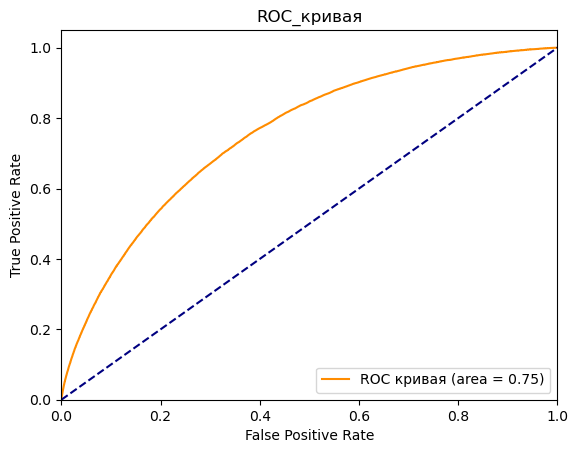

In [21]:
fpr, tpr, treshold = roc_curve(y_test, roc_pred_y)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_кривая')
plt.legend(loc="lower right")
plt.show()

In [52]:
params = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 
          'n_estimators':[750,1000,1250,1500,1750],
          'max_depth':[2,3,4,5,6,7]}

GBC = GradientBoostingClassifier(min_samples_split=2, min_samples_leaf=1, 
                                 subsample=1, max_features='sqrt', random_state=42)

tuning = GridSearchCV(estimator=GBC, param_grid = params, scoring='roc_auc', n_jobs=-1, cv=5)
tuning.fit(x_train, y_train)

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

Часть гипермараметров подбиралась по одному признаку (случайно удалены результаты вычислений), остальные подбирались совокупно
ниже информация по признакам (проверка производилась по 30% от всех данных)

In [60]:
tuning.best_params_

{'learning_rate': 0.005, 'max_depth': 7, 'n_estimators': 1750}

In [17]:
model = GradientBoostingClassifier(min_samples_split=2, min_samples_leaf=1, 
                                 subsample=1, max_features='sqrt', random_state=42,
                                 learning_rate=0.005, max_depth=7, n_estimators=1750)

In [20]:
model.fit(x_train, y_train)
roc_pred_y = model.predict_proba(x_test)[:, 1]
pred_y = model.predict(x_test)
print(model)
scores(y_test, pred_y, roc_pred_y)
print(20 * '*')

GradientBoostingClassifier(learning_rate=0.005, max_depth=7,
                           max_features='sqrt', n_estimators=1750,
                           random_state=42, subsample=1)
Матрица ошибок
 [[868040     27]
 [ 31907     26]] 

Метрика ROC-AUC 0.7540630288328024

F-мера
               precision    recall  f1-score   support

           0       0.96      1.00      0.98    868067
           1       0.49      0.00      0.00     31933

    accuracy                           0.96    900000
   macro avg       0.73      0.50      0.49    900000
weighted avg       0.95      0.96      0.95    900000

********************


## Проверка на переобученность модели на всех данных

In [ ]:
model = GradientBoostingClassifier(min_samples_split=2, min_samples_leaf=1, 
                                 subsample=1, max_features='sqrt', random_state=42,
                                 learning_rate=0.005, max_depth=7, n_estimators=1750)

In [18]:
scores = cross_val_score(model, x, y, cv=5, scoring='roc_auc')

In [19]:
scores.std()

0.008525020360810475

In [20]:
scores.mean()

0.7542997349655703

In [36]:
for i in range(len(scores)):
    print(f'На фолде №{i+1} - {round(scores[i], 2)}')

На фолде №1 - 0.77
На фолде №2 - 0.75
На фолде №3 - 0.75
На фолде №4 - 0.75
На фолде №5 - 0.75


Стандартное отклонение очень маленькое и обучение на разных фолдах почти одинаковое, что говорит о том, что модель
не переобучена и её можно применять